# Milestone Project 1: Food Vision Big

## Check GPU

Google colab offers free GPUs, however, not all of them are compatible with mixed precision training.

Google Colab offers:
* K80(no compatible)
* P100(no compatible)
* Tesla T4(compatible)


Knowing this, in order to use mixed precision training we need to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-af517c40-5459-fd9e-052f-c1e16d037348)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub:

In [2]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2024-01-13 12:23:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-13 12:23:28 (72.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Dastasets to Download Data

Overview: https://www.tensorflow.org/datasets/overview?hl=pt-br

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
dataset_list = tfds.list_builders() # get all datasets in TFDS
print('food101' in dataset_list)

True


In [6]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format(data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete10HLN5/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete10HLN5/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the  Food101 data from TensorFlow Dataset

To become one with the data, we want to find:

* Class names
* The shape of our input data(image tensors)
* The datatype of our input data
* What the labels look like (e.g are theyone-hot encoded or are they encoded)
* Do the labels macht up with the class names?

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # Samples are in format(image_tensor, label)

In [10]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 288, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 93
  Class name (str form): steak
        


In [12]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 288, 3), dtype=uint8, numpy=
array([[[148, 103,  36],
        [147, 102,  35],
        [147, 102,  35],
        ...,
        [146, 111,  53],
        [146, 111,  53],
        [146, 111,  53]],

       [[147, 102,  35],
        [147, 102,  35],
        [148, 103,  36],
        ...,
        [145, 110,  52],
        [145, 110,  52],
        [145, 110,  52]],

       [[143,  98,  31],
        [144,  99,  32],
        [146, 101,  33],
        ...,
        [146, 111,  55],
        [146, 111,  55],
        [145, 110,  54]],

       ...,

       [[113,  69,  94],
        [113,  69,  94],
        [112,  68,  93],
        ...,
        [ 77,  53,  67],
        [ 76,  52,  66],
        [ 78,  54,  68]],

       [[115,  71,  96],
        [115,  71,  96],
        [114,  70,  95],
        ...,
        [ 79,  55,  69],
        [ 81,  54,  69],
        [ 82,  55,  70]],

       [[116,  72,  97],
        [117,  73,  98],
        [117,  73,  98],
        ...,
        [ 75,  51,  6

In [13]:
# What are the min and max values?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

(-0.5, 287.5, 511.5, -0.5)

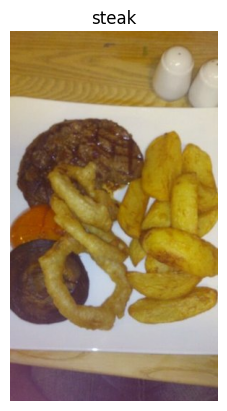

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Create preprocessing for our data

Neural networks perform best when data is in a certain way(e.g. batched, normalized, etc)

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and
map it to your data.

What we know about our data:

* In  uint8 data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In float32 data type (for mixed precision `float16` and `float32`)
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
* Scaled (values between 0 & 1), also called normalized

With these points in mind, we've got a few things we can tackle with a preprocessing function



To take care of these, we'll create a `preprocess_img()` function which:

1. Resizes an input image tensor to a specified size using `tf.image.resize()`
2. Converts an input image tensor's current datatype to `tf.float32 using tf.cast()`


> 🔑 Note: Pretrained EfficientNetBX models in tf.keras.applications.efficientnet (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "preprocess_img()" function (like the one below) or within your model as a tf.keras.layers.Rescaling layer.

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """

  image = tf.image.resize(image, [img_shape, img_shape])
  #image /= 255. # Scale image if necessary (not required for EffeNetBx)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...\nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...\nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[148 103  36]
  [147 102  35]
  [147 102  35]
  ...
  [146 111  53]
  [146 111  53]
  [146 111  53]]

 [[147 102  35]
  [147 102  35]
  [148 103  36]
  ...
  [145 110  52]
  [145 110  52]
  [145 110  52]]]...
Shape: (512, 288, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[147.30612  102.30612   35.30612 ]
  [147.27551  102.27551   35.27551 ]
  [148.61224  103.61224   36.612244]
  ...
  [145.61224  110.61225   52.612247]
  [145.35715  110.35714   52.357143]
  [145.35715  110.35714   52.357143]]

 [[142.34694   97.34694   30.34694 ]
  [144.85715   99.85714   32.42857 ]
  [146.       101.        33.      ]
  ...
  [144.14285  109.14285   53.142857]
  [144.14285  109.14285   53.142857]
  [143.2857   108.285706  52.28571 ]]]...
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

We're going to make our data input pipeline run really fast.

For more resourceson this, going through the following guide: https://www.tensorflow.org/guide/data_performance

In [17]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [18]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img,
                            num_parallel_calls=tf.data.AUTOTUNE)

# Shufle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

> Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

## Create modelling callbacks

We're going to createa couple of callbacks to helpus while our model trains:
* TensorBoard callback to log training results (so we can visualize them if need be)
* ModelCheckPoint callback to sace our model's progress after feature extraction

In [19]:
# Create tensorboard callback(import from helper_function.py)
from helper_functions import create_tensorboard_callback

# Create a ModelCheckPoint callback to save a model's progress during training
checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_acc',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

Guide for mixed precision: www.tensorflow.org/guide/mixed_precision

Mixed precision utilizesa combination of float32 and float16 data types to speed up model perfomance

In [20]:
# Turn on mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # Set global data policy to mixed precision

In [21]:
!nvidia-smi

Sat Jan 13 12:35:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              25W /  70W |    105MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [22]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [23]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# Note: EfficientNetB0 models have rescaling build-i, but if your model doesn't you can have a layer like below
# x = layers.Rescaling(1/255.)

x = base_model(inputs, training=False) # Make sure layers should be in inference model only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model= tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [24]:
# Compile the model
model.compile(loss='sparce_categorical_crossentropy',
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [26]:
## Checking layer dtype policies(are we using mixed precision/)

In [27]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:

* `layer.name (str)` : a layer's human-readable name, can be defined by the name parameter on construction
* `layer.trainable (bool)` : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's trainable attribute to False
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in


> 🔑 Note: A layer can have a dtype of float32 and a dtype policy of "mixed_float16" because it stores its variables (weights & biases) in float32 (more numerically stable), however it computes in float16 (faster).

In [28]:
# Check the layers of the base model
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [29]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretained model, the general order of doing things is:
1. Build a feature extractor model (train a couple output layers with base layers frozen)
2. Fine-tune of the frozen layers

In [30]:
model.fit(train_data,
          epochs=3,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=int(len(test_data) * 0.15),
          callbacks=[create_tensorboard_callback(dir_name='training_logs', experiment_name'efficientnetb0_101_classes_all_data_feature_extractor'),
                     model_checkpoint])

SyntaxError: positional argument follows keyword argument (<ipython-input-30-41d1707fb015>, line 7)